In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

%cd ..
%cd ..

/mnt/c/Users/maxli/OneDrive - Van Oord/Documents/thesis/code
/mnt/c/Users/maxli/OneDrive - Van Oord/Documents/thesis


In [2]:
import numpy as np
from plot_all_transects import run_kde
from atl_module.error_calc import add_true_elevation
from atl_module.bathymetry_extraction.icesat_bathymetry import add_along_track_dist
import numpy as np

In [35]:
pts = gpd.read_file("./data/test_sites/florida_keys/all_bathy_pts.gpkg")
pts = pts.set_index(pd.to_datetime(pts.delta_time))
tracklines = gpd.read_file("./data/test_sites/florida_keys/tracklines")

In [34]:
tracklines.to_crs(tracklines.estimate_utm_crs()).length

0      17919.569772
1      17918.692214
2      17779.024836
3      17780.504337
4      16096.817690
           ...     
137    16613.847297
138    12047.423037
139    11204.237897
140    14332.084721
141    15753.821510
Length: 142, dtype: float64

In [42]:
tracklines = tracklines.set_index(pd.to_datetime(tracklines.date).dt.date).set_index(
    "beam", append=True
)

In [46]:
tracklines

file Reference  \
date       beam                                                             
2018-10-17 gt2l  processed_ATL03_20181017085235_02860107_005_01       286   
           gt2r  processed_ATL03_20181017085235_02860107_005_01       286   
           gt3l  processed_ATL03_20181017085235_02860107_005_01       286   
           gt3r  processed_ATL03_20181017085235_02860107_005_01       286   
2018-12-06 gt1l  processed_ATL03_20181206181537_10560101_005_01      1056   
...                                                         ...       ...   
2022-03-30 gt2r  processed_ATL03_20220330082933_01111501_005_01       111   
           gt3l  processed_ATL03_20220330082933_01111501_005_01       111   
           gt3r  processed_ATL03_20220330082933_01111501_005_01       111   
2022-05-31 gt2l  processed_ATL03_20220531053325_10561501_005_02      1056   
           gt3l  processed_ATL03_20220531053325_10561501_005_02      1056   

                                        date beam_type  total_phot  \
date       beam                                                      
2018-10-17 gt2l  2018-10-17T08:52:33.702031Z      weak       12995   
           gt2r  2018-10-17T08:52:33.702031Z    strong       41968   
           gt3l  2018-10-17T08:52:33.702031Z      weak       13584   
           gt3r  2018-10-17T08:52:33.702031Z    strong       55777   
2018-12-06 gt1l  2018-12-06T18:15:36.991948Z      weak       41006   
...                                      ...       ...         ...   
2022-03-30 gt2r  2022-03-30T08:29:32.375420Z      weak        7090   
           gt3l  2022-03-30T08:29:32.375420Z    strong       22245   
           gt3r  2022-03-30T08:29:32.375420Z      weak        5030   
2022-05-31 gt2l  2022-05-31T05:33:26.375253Z    strong         216   
           gt3l  2022-05-31T05:33:26.375253Z    strong         457   

                 secchi_dep  secchi_d_1  \
date       beam                           
2018-10-17 gt2l   14.269845   62.899998   
           gt2r   14.269845   62.899998   
           gt3l   14.269845   62.899998   
           gt3r   14.269845   62.899998   
2018-12-06 gt1l    9.680401   55.149998   
...                     ...         ...   
2022-03-30 gt2r   11.832424   56.070000   
           gt3l   10.750420   55.049999   
           gt3r   10.750420   55.049999   
2022-05-31 gt2l    6.816780   61.619999   
           gt3l    8.237118   62.230000   

                                                          geometry  
date       beam                                                     
2018-10-17 gt2l  LINESTRING (-80.88903 24.69379, -80.87173 24.8...  
           gt2r  LINESTRING (-80.88988 24.69349, -80.87259 24.8...  
           gt3l  LINESTRING (-80.92181 24.68362, -80.90469 24.8...  
           gt3r  LINESTRING (-80.92274 24.68333, -80.90562 24.8...  
2018-12-06 gt1l  LINESTRING (-81.03732 24.64788, -81.05291 24.7...  
...                                                            ...  
2022-03-30 gt2r  LINESTRING (-80.89218 24.69292, -80.90822 24.8...  
           gt3l  LINESTRING (-80.86688 24.74430, -80.87849 24.8...  
           gt3r  LINESTRING (-80.86681 24.75212, -80.87761 24.8...  
2022-05-31 gt2l  LINESTRING (-81.14391 24.61500, -81.15778 24.7...  
           gt3l  LINESTRING (-81.11330 24.62475, -81.12845 24.7...  

[142 rows x 8 columns]

In [52]:
bytrack = pts.groupby([pts.index.date, "beam"]).agg(["count", "mean"])
bytrack

/tmp/ipykernel_16127/20035709.py:1: FutureWarning: ['atm_profile', 'beamtype', 'geometry'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  bytrack = pts.groupby([pts.index.date,'beam']).agg(['count','mean'])


X                Y            Z_ellip            Z_geoid  \
                count       mean count       mean   count       mean   count   
           beam                                                                
2018-10-17 gt2l  1869 -80.878465  1869  24.792168    1869 -30.281777    1869   
           gt2r  5216 -80.879529  5216  24.789938    5216 -30.223655    5216   
           gt3l  1557 -80.908819  1557  24.804912    1557 -28.324553    1557   
           gt3r  5735 -80.909224  5735  24.809528    5735 -27.994301    5735   
2018-12-06 gt1r  2422 -81.044897  2422  24.725106    2422 -32.179399    2422   
...               ...        ...   ...        ...     ...        ...     ...   
2022-03-30 gt2l  3062 -80.905082  3062  24.804413    3062 -28.302224    3062   
           gt2r  1113 -80.903865  1113  24.801675    1113 -28.679351    1113   
           gt3l  2912 -80.875702  2912  24.826628    2912 -28.691384    2912   
           gt3r   633 -80.875364   633  24.831899     633 -28.600942     633   
2022-05-31 gt3l    10 -81.115475    10  24.644884      10 -37.329070      10   

                           geoid_corr             ... northing_raw  \
                      mean      count       mean  ...        count   
           beam                                   ...                
2018-10-17 gt2l  -5.926142       1869 -24.542769  ...         1869   
           gt2r  -5.870993       5216 -24.539991  ...         5216   
           gt3l  -4.019176       1557 -24.487945  ...         1557   
           gt3r  -3.684606       5735 -24.491599  ...         5735   
2018-12-06 gt1r  -8.149647       2422 -24.162838  ...         2422   
...                    ...        ...        ...  ...          ...   
2022-03-30 gt2l  -3.679874       3062 -24.495635  ...         3062   
           gt2r  -4.057394       1113 -24.496031  ...         1113   
           gt3l  -3.988293       2912 -24.577322  ...         2912   
           gt3r  -3.890342        633 -24.583847  ...          633   
2022-05-31 gt3l -13.257817         10 -24.156662  ...           10   

                              sf_elev_MSL           true_elevation             \
                         mean       count      mean          count       mean   
           beam                                                                 
2018-10-17 gt2l  2.741941e+06        1869 -3.460862           1861  -3.769739   
           gt2r  2.741694e+06        5216 -3.684234           5213  -3.750173   
           gt3l  2.743349e+06        1557 -2.198161           1557  -2.235085   
           gt3r  2.743860e+06        5735 -2.130744           5735  -2.055294   
2018-12-06 gt1r  2.734510e+06        2422 -2.827791           2417  -2.405782   
...                       ...         ...       ...            ...        ...   
2022-03-30 gt2l  2.743294e+06        3062 -2.462773           3062  -2.274997   
           gt2r  2.742991e+06        1113 -2.633081           1113  -2.401593   
           gt3l  2.745756e+06        2912 -2.801505           2888  -2.594387   
           gt3r  2.746340e+06         633 -2.757158            633  -2.448983   
2022-05-31 gt3l  2.725632e+06          10 -5.281491             10 -10.434115   

                error           error_abs            
                count      mean     count      mean  
           beam                                      
2018-10-17 gt2l  1861 -0.302715      1861  0.684121  
           gt2r  5213 -0.064866      5213  0.530518  
           gt3l  1557 -0.036924      1557  0.467737  
           gt3r  5735  0.075450      5735  0.307100  
2018-12-06 gt1r  2417  0.421753      2417  0.425194  
...               ...       ...       ...       ...  
2022-03-30 gt2l  3062  0.187776      3062  0.279912  
           gt2r  1113  0.231489      1113  0.286758  
           gt3l  2888  0.212060      2888  0.233111  
           gt3r   633  0.308174       633  0.308174  
2022-05-31 gt3l    10 -5.152624        10  5.152624  

[105 rows x 60 columns]

In [ ]:
filename, beam = (
    "./data/test_sites/oahu6/ATL03/processed_ATL03_20191014204022_02740507_005_01.nc",
    "gt3r",
)

In [ ]:
subsurface, bathydf = run_kde(filename, beam)
wtruth = add_true_elevation(
    bathydf, "./data/test_sites/oahu6/in-situ-DEM/truth.vrt", crs=pts.crs
)
wtruth = add_along_track_dist(wtruth)
wtruth = wtruth.assign(error=wtruth.true_elevation - wtruth.z_kde)
wtruth = wtruth.assign(sqerror=wtruth.error**2)

In [ ]:
nbins = 100
# wtruth.groupby(pd.cut(wtruth.delta_time,nbins)).agg({'X':'count','sqerror':'mean','kde_val':'mean'}).plot.scatter(y='sqerror',x='X')
wtruth.groupby(pd.cut(wtruth.delta_time, nbins)).agg(
    {"X": "count", "kde_val": "mean", "sqerror": lambda x: np.power(np.mean(x), 0.5)}
).plot.scatter(y="sqerror", x="kde_val")

In [ ]:
wtruth.plot.scatter(x="delta_time", y="z_kde")

In [ ]:
subsurface.columns

In [ ]:
subsurface.sea_level_interp.iloc[0]

In [ ]:
wtruth.plot.scatter(x="error", y="full_sat")

In [ ]:
wtruth.plot.scatter(x="error", y="ph_count")

<AxesSubplot:xlabel='error', ylabel='kde_val'>

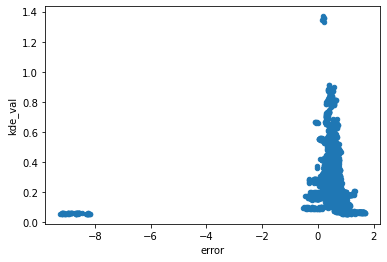

In [24]:
wtruth.plot.scatter(x="error", y="kde_val")

In [11]:
pts = gpd.read_file("./data/test_sites/florida_keys/all_bathy_pts.gpkg")
tracklines = gpd.read_file("./data/test_sites/florida_keys/tracklines")
# date_indexed_tracklines  = tracklines.assign(date = pd.to_datetime(tracklines.date).dt.date).reset_index().set_index(['date','beam'])

add analysis of how much bathymetry each transect contains

In [4]:
pts.columns

Index(['X', 'Y', 'Z_ellip', 'Z_geoid', 'geoid_corr', 'tide_ocean_corr',
       'geof2m_corr', 'delta_time', 'oc_sig_conf', 'land_sig_conf', 'p_vec_az',
       'p_vec_elev', 'dac_corr', 'ph_count', 'full_sat', 'gebco_elev',
       'sea_level_interp', 'Z_refr', 'easting_corr', 'northing_corr', 'z_kde',
       'kde_val', 'beam', 'atm_profile', 'beamtype', 'oc_hconf_perc',
       'easting_raw', 'northing_raw', 'sf_elev_MSL', 'true_elevation', 'error',
       'error_abs', 'geometry'],
      dtype='object')

In [5]:
def r2_rmse(g):
    r2 = r2_score(g["true_elevation"], g["sf_elev_MSL"])
    rmse = np.sqrt(mean_squared_error(g["true_elevation"], g["sf_elev_MSL"]))
    return pd.Series(dict(r2=r2, rmse=rmse))


def all_metrics(g):
    true_value = g["true_elevation"]
    estimated_value = g["sf_elev_MSL"]
    r2 = r2_score(true_value, estimated_value)
    rmse = np.sqrt(mean_squared_error(true_value, estimated_value))
    mape = mean_absolute_percentage_error(true_value, estimated_value)
    mae = mean_absolute_error(true_value, estimated_value)
    davg = g["true_elevation"].mean()
    min_dep = g["true_elevation"].min()
    return pd.Series(
        {
            "R^2": r2,
            "RMSE": rmse,
            "MAPE": mape,
            "MAE": mae,
            "Mean depth": davg,
            "Minimum Depth": min_dep,
        }
    )

In [6]:
pts.dropna().groupby("oc_sig_conf").apply(all_metrics)

,R^2,RMSE,MAPE,MAE,Mean depth,Minimum Depth
oc_sig_conf,,,,,,
0,0.965976,0.509951,0.201171,0.421832,-4.979960,-11.258467
1,0.957928,0.477637,0.128759,0.381858,-3.916029,-12.450810
2,0.923631,0.367706,0.122403,0.331502,-3.105554,-8.511455
3,0.905147,0.586685,0.153261,0.398556,-3.338892,-11.506279
4,0.917405,0.500327,0.153290,0.345702,-3.006850,-12.401400


In [7]:
pts.dropna().groupby("beamtype").apply(all_metrics)

,R^2,RMSE,MAPE,MAE,Mean depth,Minimum Depth
beamtype,,,,,,
strong,0.951025,0.471199,0.137185,0.356304,-3.463713,-12.450810
weak,0.910897,0.566870,0.173716,0.387760,-3.267408,-10.856376


<AxesSubplot:xlabel='true_elevation', ylabel='sf_elev_MSL'>

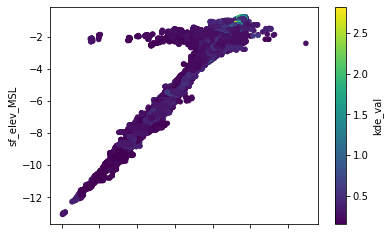

In [8]:
pts.plot.scatter(y="sf_elev_MSL", x="true_elevation", c="kde_val", cmap="viridis")

<AxesSubplot:xlabel='kde_val', ylabel='error_abs'>

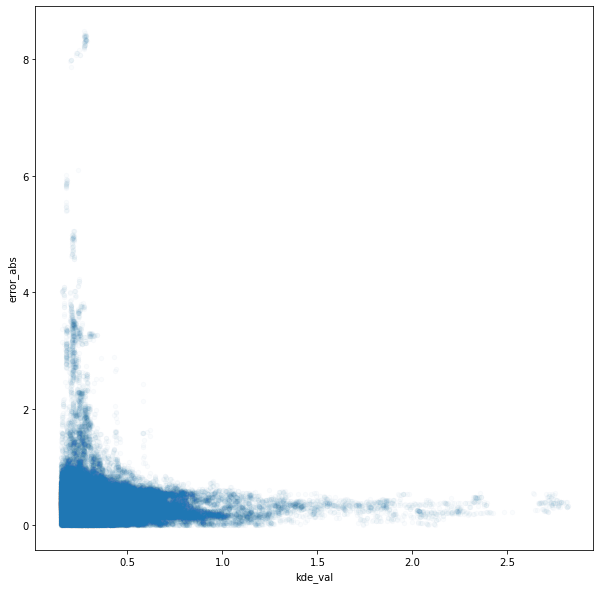

In [9]:
pts.plot.scatter(y="error_abs", x="kde_val", figsize=(10, 10), alpha=0.02)

In [10]:
df = (
    pts.groupby(
        [
            pd.to_datetime(pts.rename(columns={"delta_time": "date"}).date).dt.date,
            "beam",
        ]
    )
    .mean()
    .sort_values("error", ascending=False)
)
df = df.merge(date_indexed_tracklines, how="left", left_index=True, right_index=True)

NameError: name 'date_indexed_tracklines' is not defined